# CSCI2951-F Assignment 3: Policy Gradients and Actor-Critic Algorithms


Name: **Sergio Orozco**

Welcome to Assignment 3. This notebook will help you understand:
- Function approximation and its limitations.
- Stochastic policies.
- Policy gradients.
- Actor-critic algorithms.


## Preliminaries
You'll need three imports to complete this assigment:
- numpy: The fundamental package for scientific computing with Python.
- matplotlib: Used for scientific visualization of data in Python.
- gymnasium: A ubiquitous library for standard environments for reinforcement learning.
```console
pip install gymnasium
```
- gridworld: A module containing the 4x3 GridWorld we've been working with.
- pygame: A module required for visualizaing the cartpole environment.
```console
pip install pygame
```
- tools: A module for helper functions and plotting.

Please do not change the imports and answer the written questions in a separate document. If you run into issues installing the libraries please let us know ASAP. 

In [1]:
%%capture
%matplotlib inline

In [2]:
import copy
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from gridworld import SwitchGridWorld, MDP
from tools import functional_feature_value_determination, FourierFeatures, visualize_softmax_policy

## Section 1: Function Approximation and Stochastic Policies

Previously in the 4x3 GridWorld, we represented state as a **feature vector** of length $k$, defined by the function $\phi$ such that the agent's positional $x$ and $y$ values were encoded by one-hot vectors:

$$\phi(0) = [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],$$
$$\phi(1) = [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],$$

In our previous assignment, we used __linear__ value function approximation to estimate a value function over these features. So for the feature vector $\mathbf{w}$, taking the dot product of this weight vector with, for example, the $\phi(0)$ feature vector:
$$
\phi(0) \cdot \mathbf{w} = w_0 + w_4.
$$

This means that **all** states in column 0 of the 4x3 GridWorld will have value function estimates that have a $w_4$ component in them. Function approximation allows us to __generalize__ across states, as opposed to fully __discriminating__ between states. This generalization capability of function approximation becomes vastly more important when our state space is very large, where it might be computationally intractable to learn a value for each possible state (for instance, in continuous state spaces). 

In the featurization scheme introduced in 4x3, we made features that were not able to fully discriminate between all states, but was good enough to fit the optimal value function. What if we have a featurization scheme that generalizes **too much**?

### Switching Actions GridWorld
Let's consider the following 4-state GridWorld:
![Switch GridWorld](switch_grid_world.png)
The start state is denoted by S, while the goal state is labelled by G. State indices are labelled in blue. There are two actions in this environment: `left` and `right`. `left` and `right` transitions happen as expected in each state, except in the middle state (index 1), with the swapped arrows. In this state, the `left` action goes to the state to the right (index 2), while the `right` action goes to the state to the left (index 0). The reward at every time step is -1.

In this specific example, all states are mapped to the same feature:

$$\phi(0) = \phi(1) = \phi(2) = [1].$$

Which is a 1-dimensional vector with a 1 as its only element.

We have an issue if all states are mapped to the same value. Ideally, we would want to take the `left` action in state 1, and take the `right` action elsewhere. But now our agent is unable to discriminate between states. This means our policy can only be one of two things: 

$$\pi(\phi(s)) = \pi([1]) = \text{left}$$

or

$$\pi(\phi(s)) = \pi([1]) = \text{right}.$$

Let's see what the value function of these two policies look like for this GridWorld with this featurization scheme below. Note, that we represent our two policies as $1 \times |A|$ matrices, since our features are just defined over one possible state feature. The inner $|A|$ vector represents a one-hot representation of the discrete action. Our feature function is represented by a $S \times \Phi$ matrix, which maps one-hot state indices to our new feature space.

In [4]:
env = SwitchGridWorld()
pi_left = np.array([[1, 0]])   # LEFT policy
pi_right = np.array([[0, 1]])  # RIGHT policy

# Featurization described above.
# Phi is a matrix that maps all (one-hot) state indices to a single observation.
# We have an extra state here for the goal state.
phi = np.array([
    [1],
    [1],
    [1],
    [1]
])
v_left, _ = functional_feature_value_determination(pi_left, phi, env)
v_right, _ = functional_feature_value_determination(pi_right, phi, env)
v_left, v_right

(array([-10.]), array([-10.]))

### QUESTION
1.1 Why are both the value functions the same (-10) values? Provide a closed-form derivation for the value. (Hint: consider what the discount rate `env.gamma` is.)

### Stochastic Policies
Stochastic policies are policies where you take actions with differing probabilities, and is represented as a conditional probability distribution:

$$\pi(a \mid s) = Pr(a \mid s).$$

Let's consider a stochastic policy over state indices in the switching actions GridWorld. In state index 0, this policy will take the `left` action with probability 0.3, and will take the `right` action with $1 - 0.3 = 0.7$ probability. We can represent this policy conditioned on this state as the following vector of probabilities:

$$\pi(\cdot \mid 0) = [0.3, 0.7].$$

Now let's consider the policy where $\pi(\cdot \mid 0)$ is defined as above, but for the rest of the states, the policy chooses `right` deterministically. This policy would look like so:
$$
\pi = \begin{bmatrix}
0.3 & 0.7 \\
0.0 & 1.0 \\
0.0 & 1.0 \\
0.0 & 1.0
\end{bmatrix}.
$$

Which is a $|S| \times |A|$ matrix, where each row represents $\pi(\cdot \mid s)$.

The possibility of taking actions __stochastically__ opens up corridors for cases where states are mapped together. Let's consider the policy over our featurization:
$$\pi(\cdot \mid \phi(s)) = [0.3, 0.7]$$
and calculate our value function over this. Note: the policy parameterization here only depends on a single parameter, since the policy in this case is a Bernoulli distribution over the actions `left` and `right`. This means that the policy only depends on a single parameter $p$ which we denote to represent the probability of taking `left`. The parameter the represents the `right` action probability is then $1 - p$.

In [5]:
p = 0.2
pi = np.array([[p, 1 - p]])
v, _ = functional_feature_value_determination(pi, phi, env)
v

array([-4.03001372])

We get a higher value. Let's investigate why. We first consider the __policy-conditioned transition function__ $P^{\pi}$, which is a $S \times S$ matrix if $S$ is discrete. Let's build two state-to-state transition functions for the "always `right`" policy and the always $[p, 1 - p]$ policies:
$$
\pi_{right} = \begin{bmatrix}
0.0 & 1.0 \\
0.0 & 1.0 \\
0.0 & 1.0 \\
0.0 & 1.0
\end{bmatrix},
\pi_{p} = \begin{bmatrix}
p & (1 - p) \\
p & (1 - p) \\
p & (1 - p) \\
p & (1 - p) \\
\end{bmatrix}.
$$
Since all rows are the same, this policy is equivalent to the feature-based policy for all $s \in S$ for this featurization. 

In [49]:
def get_P_pi_right(mdp: MDP):
    """
    We want you to return the S X S transition matrix for the policy that 
    choses right deterministacally. This can be specific to our example
    of switching actions GridWorld.
    """
    
    
    P_pi = np.zeros((4, 4))
   
    ### START CODE HERE ###
    P_pi[0,1] = 1
    P_pi[1,0] = 1
    P_pi[2,3] = 1
    P_pi[3,3] = 1
    ### END CODE HERE ###
    return P_pi
    
def get_P_pi_p(mdp: MDP, p: float):
    """
    We want you to return the S X S transition matrix for the policy that 
    choses action go left with probability p. This can be specific to our example
    of switching actions GridWorld.
    """
    
    P_pi = np.zeros((4, 4))
    
    ### START CODE HERE ###
    P_pi[0,0] = p
    P_pi[0,1] = 1-p
    
    P_pi[1,0] = p
    P_pi[1,2] = 1-p
    
    P_pi[2,1] = p
    P_pi[2,3] = 1-p

    P_pi[3,3] = 1
    ### END CODE HERE ###

    return P_pi


Let's see what a 10-step transition function looks for $P^{\pi_{right}}$ and two $P^{\pi_p}$ matrices:

In [50]:
P_pi_right = get_P_pi_right(env)

p1 = 0.1
P_pi_p1 = get_P_pi_p(env, p1)

p2 = 0.4
P_pi_p2 = get_P_pi_p(env, p2)

print(P_pi_right)
print(P_pi_p1)
print(P_pi_p2)

np.linalg.matrix_power(P_pi_right, 10), np.linalg.matrix_power(P_pi_p1, 10), np.linalg.matrix_power(P_pi_p2, 10)

[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
[[0.1 0.9 0.  0. ]
 [0.1 0.  0.9 0. ]
 [0.  0.1 0.  0.9]
 [0.  0.  0.  1. ]]
[[0.4 0.6 0.  0. ]
 [0.4 0.  0.6 0. ]
 [0.  0.4 0.  0.6]
 [0.  0.  0.  1. ]]


(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]),
 array([[1.43175700e-04, 3.27321900e-04, 1.09234170e-03, 9.98437161e-01],
        [3.63691000e-05, 2.28177900e-04, 2.05950600e-04, 9.99529502e-01],
        [1.34857000e-05, 2.28834000e-05, 1.06806600e-04, 9.99856824e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[0.08232632, 0.08597668, 0.06623724, 0.76545976],
        [0.05731779, 0.06916669, 0.04181852, 0.831697  ],
        [0.02943877, 0.02787901, 0.02500854, 0.91767368],
        [0.        , 0.        , 0.        , 1.        ]]))

### QUESTION
1.2 These matrices tell you with what probability you will end up in state $s'$ if you started in $s$ and took $n = 10$ steps. 
Consider the elements in the above matrices. Which element (give an $i, j$ index) informs us about what value we might get w.r.t. $p$? Explain your reasoning.

### Visualizing the Value Function Over Policies
We've seen that a stochastic policy gives us better performance. Which leads us to the question, for what values of $p$ is the policy optimal? Let's find out.

Below we ask you to code up two functions: `values_over_range` and `find_max_p`. `values_over_range` finds the values for $p \in [0, 1]$, discretized into `n_bins`. `find_max_p` returns the maximum value and $p$.

In [82]:
def values_over_range(
    phi: np.ndarray,
    env: MDP,
    n_bins: int = 100) -> np.ndarray:
    """
    Find the values over a range of possible p's, where p is defined as
    \pi(left | \phi(s)) = p.
    The parameter n_bins specifies the number of evenly spaced numbers over the interval [0, 1].
    You should be using functional_feature_value_determination in this function.
    Hint: take a look at the np.linspace function.
    """
    all_vals = np.zeros(n_bins) # These are simply placeholders
    all_ps = np.zeros(n_bins) # You can change these values
    
    ### START CODE HERE ###

    all_ps = np.linspace(0, 1, num=n_bins)

    all_vals = []

    # find the value for each p value
    for i in range(n_bins):
        p = all_ps[i]
        pi = np.array([[p, 1 - p]])
        val, _ = functional_feature_value_determination(pi, phi, env)
        all_vals.append(val)

    # for some reason numpy did not like me changing the elements in the original array
    all_vals = np.array(all_vals)
    ### END CODE HERE ###
    
    return all_vals, all_ps

def find_max_p(phi: np.ndarray, env: MDP) -> float:
    """
    Find the value of p that maximizes the value function.
    Hint: you should probably be using the above function to do this.
    """
    max_p = 0.0
    max_val = 0.0
    ### START CODE HERE ###
    
    all_vals, all_ps = values_over_range(phi,env)

    # find best value index
    i = np.argmax(all_vals)
    
    max_p = all_ps[i]
    max_val = all_vals[i]
    ### END CODE HERE ###
    
    return max_p, max_val

In [83]:
# Find our max p for Switching GridWorld
max_p, max_val = find_max_p(phi, env)
max_p, max_val

(0.4141414141414142, array([-3.27490182]))

Now let's plot these values over $p$.

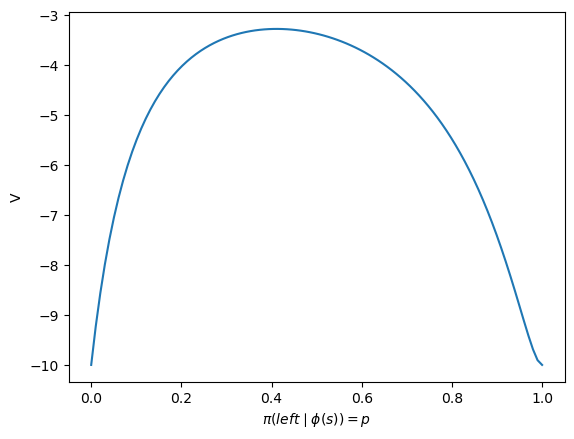

In [84]:
vals, ps = values_over_range(phi, env)

plt.plot(ps, vals)

plt.xlabel('$\pi(left \mid \phi(s)) = p$')
plt.ylabel('V')
plt.show()

## Section 2: Policy Gradient
In the above example, we've manually found the optimal policy for Switching GridWorld. In this section, we'll be calculating the policy gradient in order to find this probability. You'll be implementing the REINFORCE algorithm that you saw in class. Before we do that, we need to consider policy parameterization.

### Softmax Policies
In class, we were introduced to __softmax__ policies of the form

$$
\pi(a \mid \phi(s), \mathbf{\theta}) = \frac{\exp{(h(\phi(s), a, \mathbf{\theta}))}}{\sum_{b}\exp{(h(\phi(s), b, \mathbf{\theta}))}}.
$$

You might be familiar with the softmax function in your machine learning class. We'll be using it with linear weights over our state features to parameterize our policy:

$$
\pi_{\mathbf{\theta}}(a \mid \phi(s)) = \frac{\exp{(\mathbf{\theta}_a^{\intercal}\phi(s))}}{\sum_{b}\exp{(\mathbf{\theta}_b^{\intercal}\phi(s))}}.
$$

where again we have separate weights for each discrete action $a \in A$, represented as $\mathbf{\theta}_a$ like in Q-learning for Assignment 2. Implement the softmax policy below.
Note: we've also implemented the gradient of the log probabilities of a softmax policy below, which depends on your `softmax_pi` function.

In [92]:
def softmax_pi_distribution(theta: np.ndarray, phi_s: np.ndarray) -> np.ndarray:
    """
    Given a set of weights theta (of size A x \Phi) and state features 
    phi_s (a vector of size \Phi), return the probability distribution 
    over actions.
    """
    pi = np.zeros(theta.shape[0])
    pi [1] = 1.0 #Change this, this is a place holder
    
    ### START CODE HERE ###
    normalizer = 0

    ## calculate the denominator
    for i in range(theta.shape[0]):
        normalizer += np.exp(np.dot(theta[i].T,phi_s))

    # calculate the stochastic policy
    for i in range(theta.shape[0]):
        pi[i] = np.exp(np.dot(theta[i].T,phi_s)) / normalizer
    
    ### END CODE HERE ###
    
    return pi

def softmax_pi(theta: np.ndarray, phi_s: np.ndarray) -> int:
    """
    Samples an action from \pi(\cdot \mid \phi(s)).
    """
    pi = softmax_pi_distribution(theta, phi_s)
    return np.random.choice(theta.shape[0], p=pi)

def grad_log_softmax(theta: np.ndarray, phi_s: np.ndarray, a: int):
    """
    Gradient of the log policy probability of an action a given state 
    features phi_s.
    Normally, an autodifferentiation package would do this for you.
    """
    grad = np.zeros_like(theta)
    grad[a] += (phi_s * (1 - softmax_pi_distribution(theta, phi_s)[a]))
    for b in range(theta.shape[0]):
        if b == a:
            continue
        grad[b] -= (phi_s * softmax_pi_distribution(theta, phi_s)[b])
    return grad


### Policy Gradient
Now that we've defined our policy parameterization, we can try and optimize it using the policy gradient. From class, we've seen the policy gradient written as
$$
\begin{align*}
    \nabla U(\mathbf{\theta}) &= \mathbb{E}_{\tau}\left[\nabla_{\mathbf{\theta}} \log p_{\mathbf{\theta}}(\tau) R(\tau)\right]\\
    &= \mathbb{E}_{\tau}\left[ \sum_{k = 1}^d \nabla_{\mathbf{\theta}} \log \pi_{\mathbf{\theta}}(a^{(k)} \mid s^{(k)}) R(\tau)\right].
\end{align*}
$$
Where $\log \pi_{\mathbf{\theta}}(a^k \mid s^k)$ is the log probability of the action $a^{(k)}$ and state $s^{(k)}$ for time step $k$, and $R(\tau)$ is the discounted trajectory return. The REINFORCE algorithm learns the optimal policy weights by __ascending__ this gradient direction to maximize $U(\mathbf{\theta})$. As a reminder, the REINFORCE algorithm is structured as so:
1. Sample a trajectory $\tau$ given the current parameterized policy $\pi_{\mathbf{\theta}}$
2. Compute the discounted sum of returns, $R(\tau)$.
3. Multiply the discounted sum of returns by $\sum_{k = 1}^d \nabla_{\mathbf{\theta}} \log \pi_{\mathbf{\theta}}(a^{(k)} \mid s^{(k)})$.
4. Use this update rule to make a (small) gradient update step to your parameters.
5. Repeat the steps above

Implement the policy gradient algorithm below. We've provided you with a function, `grad_log_softmax` that calculates $\nabla_{\mathbf{\theta}} \log \pi_{\mathbf{\theta}}(a^{(k)} \mid s^{(k)})$ for you. We've also provided the `rollout` and `discounted_return` functions, which you implemented in the previous assignment.

In [100]:
def discounted_return(ep_rewards: np.ndarray[float], gamma) -> float:
    """
    Given an array of rewards we return the discounted return.
    """
    return np.dot(gamma ** np.arange(len(ep_rewards)), ep_rewards)


def rollout(env, theta: np.ndarray[int]) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    We take as input an environment and policy parameters w. We perform a single rollout.
    This rollout takes an action according to the policy pi and transitions according
    to the step function.
    """
    # Two lists for rewards and features
    ep_features = []
    ep_actions = []
    ep_rewards = []

    obs, _ = env.reset()
    ep_features.append(obs)
    
    terminal, truncation = False, False

    while not (terminal or truncation):
        action = softmax_pi(theta, obs)
        obs, reward, terminal, truncation, _ = env.step(action)
        ep_features.append(obs)
        ep_actions.append(action)
        ep_rewards.append(reward)

    return np.array(ep_features), np.array(ep_actions), np.array(ep_rewards)

def reinforce(env, num_samples: int = 10000, alpha: float = 0.001):
    """
    Trajectory-based REINFORCE algorithm (see Policy Search slides, page 12).
    In this algorithm, we DON'T need to calculate updates for each
    action individually (like we did in Q-learning). The function 
    grad_log_softmax calculates gradients for the ENTIRE weight vector \theta.
    
    :param env: The environment to run REINFORCE over.
    :param num_samples: The number of environment steps to run REINFORCE
        over. If the last trajectory goes over this number, that's fine.
        We use num_samples as opposed to number of trajectories since
        trajectory lengths can get very long in this (potentially)
        infinite horizon problem.
    :param alpha: The step size of the updates.
    """
    theta = np.zeros((env.action_space.n, env.observation_space.shape[0]))
    
    ### START CODE HERE ###
    gamma = 0.9

    current_samples = 0

    # iterate for num_samples (or atleast close to)
    while current_samples < num_samples:
        ep_features, ep_actions, ep_rewards = rollout(env,theta)
        discounted_rewards = discounted_return(ep_rewards,gamma)

        # calculate all log softmaxes
        policy_gradient = 0
        for s,a in zip(ep_features,ep_actions):
            policy_gradient += grad_log_softmax(theta,s, a)

        # calculate gradient
        update = discounted_rewards * policy_gradient

        theta = theta + alpha*update

        current_samples += len(ep_features)
    
    ### END CODE HERE ###
    
    return theta

Now let's run this algorithm on the Switching GridWorld we introduced earlier.

In [101]:
theta = reinforce(env, num_samples=int(1e6), alpha=1e-5)

In [102]:
softmax_pi_distribution(theta, np.array([1, 0]))

array([0.41423627, 0.58576373])

As we can see, we need around a million samples with a very small step size for REINFORCE to get close to the optimal solution for our very small 4-state MDP with featurization. We can see the variance of the learned olicy from REINFORCE by running __multiple runs__ with a slightly larger step size and less samples:

In [103]:
p_samples = []
for i in range(10):
    theta = reinforce(env, num_samples=int(5e4), alpha=1e-4)
    p_samples.append(softmax_pi_distribution(theta, np.array([1, 0]))[0])

p_samples = np.array(p_samples)
p_samples

array([0.44159674, 0.4260008 , 0.42711076, 0.45094632, 0.39349324,
       0.44993675, 0.43403077, 0.48788113, 0.45936347, 0.47504251])

## Section 3: Variance Reduction with Baselines and Actor-Critic Algorithms

Now let's consider a further variance reduction technique: subtracting a baseline. First, let's consider a baseline that does not depend on actions. Our step-based policy gradient update, with a baseline takes the form:
$$
\nabla U(\mathbf{\theta}) = \nabla_{\mathbf{\theta}} \mathbb{E}_{\tau}\left[ \sum_{k = 1}^d \log \pi_{\mathbf{\theta}}(a^{(k)} \mid s^{(k)}) \gamma^{k - 1} \left(r^{(k)}_{\text{to-go}} - b_{\text{base}}(s^{(k)})\right) \right]
$$
where $b_{\text{base}}(s^{(k)})$ is our state-dependent baseline. A common baseline to use is an estimated value function $\hat{V}(s^{(k)})$. We saw in chapter 11 of the textbook that this does not bias our gradient.

### QUESTION
**3.1:** Modern optimization methods take gradient steps in the direction of the objective. Suppose $\theta$ are the parameters that we seek to optimize, $U(\theta)$ is the objective, and $\nabla_{\theta} U(\theta)$ represents the true gradient. Usually, you start with an initialization $\theta^{(0)}$ and obtain a sequence of parameters: $\theta^{(0)}, \theta^{(1)}, \dots \theta^{(l)}$ over $l$ gradient steps. Ideally, the updates are supposed to be in direction of the gradient: $\theta^{(1)} = \theta^{(0)} + \alpha \nabla_{\theta} U(\theta) |_{\theta = \theta^{(0)}}$, where $\nabla_{\theta} U(\theta) |_{\theta = \theta^{(0)}}$ is the true gradient evaluated at the value $\theta_0$ and $\alpha$ is the learning rate. That is not always the case. As in policy gradient, we don't have an exact solution or the exact functional form for the gradient $\nabla_{\theta} U(\theta)$ so we instead obtain a sample based estimate. For the REINFORCE policy gradient algorithm it is:
\begin{equation*}
    \nabla_{\theta} U(\theta) \approx \frac{1}{N} \sum_{i = 1}^{N} \nabla_{\theta} \log \pi_{\theta} (a^{(i)} | s^{(i)}) \left (\sum_{k = 0}^{T_i - 1} \gamma^k r_i^{(k)} \right),
\end{equation*}
where  $r_i^{(k)}$ is the reward observed for the trajectory at time $k$. We denote by $g^{(l)}$ our gradient estimate at the gradient step $l$. So we have $\theta^{(l + 1)} = \theta^{(l)} + \alpha g^{(l)}$. As in any estimate, $g^{(l)}$ also has some randomness or stochasticity in it. This estimate can be "noisy" at times and it can affect how effective the learning algorithm is. More concretely, optimization theory tells us that the improvement in the discounted return from one stochastic gradient step using the gradient estimate $g^{(l)}$ has the following upper bound:
\begin{equation*}
    \mathbb E \left [ U(\theta^{(l + 1)}) \right ] - U(\theta^{(l)}) \leq \left (\alpha - \frac{L \alpha^2}{2} \right ) ||\mathbb E \left [ g^{(l)} \right ]||_2 -  \frac{L \alpha^2}{2} \text{Var}(g^{(l)}),
\end{equation*}
where $\text{Var}$ is the variance and $L$ is the Lipschitz constant corresponding to the gradients.
You might also observe how you needed a small learning rate, $\alpha$, to deal with high variance in the above inequality. Specifically, the variance of a scalar random variable $X$ is $\mathbb E \left [(X - \mu)^2 \right ]$ where $\mu$ is the mean of $X$. This can be further simplified to $\mathbb E \left [X^2 \right ] - \mathbb E \left [ X \right ]^2$.

 We want you to show how the variance of the gradient blows up for REINFORCE algorithm. Let the REINFORCE gradient be
\begin{equation*}
    g(\theta) = \left( \sum_{k = 0}^{T - 1} \nabla_{\theta} \log(\pi_{\theta}(a^{(k)} | s^{(k)})) \right) \left (\sum_{k = 0}^{T - 1}  r^{(k)}\right ).
\end{equation*}
For simplicity, consider an MDP with constant horizon $H$, i.e. constant number of time steps in every episode, and constant reward $r(s, a) = c$ for all $s,a $, and $\gamma = 1$.
We want you show that the variance of the gradient estimate grows cubically in the length of the horizon $H$, in case of the constant reward formulation above, given that the variance of the gradient log of policy is bounded above by a constant, succinctly $\text{Var} \left (\nabla_{\theta_j} \log(\pi_{\theta} (a^{(k)} | a^{(k)} )) \right ) =  O(1)$, for all $j$.


To do so we want you to simplify the following expression. 

$$\text{Var}(g_j(\theta)) = \mathbb E_{\tau} \left [X^2 \right ] - \mathbb E_{\tau} \left [ X \right ]^2,$$

where $X =  \left( \sum_{k = 0}^{T - 1} \nabla_{\theta_j} \log(\pi_{\theta}(a^{(k)} | s^{(k)})) \right) \left (\sum_{k = 0}^{T - 1}  r^{(k)}\right )$ is the gradient of the objective with respect to the $j$-th element of the parameter vector. It is sufficient to show this cubic relationship between the episode length $H$ and variance of the gradient with respect to an arbitrary element of the parameter vector.

Another hint is that you can decompose $\text{Var}(g_j)$ in terms of summations of $\text{Var}\left (\nabla_{\theta_j} \log(\pi_{\theta} (a^{(k)} | a^{(k)} )) \right )$ and to do so remember that for two independent random variables, $Y, Y'$, we have $\text{Var}(Y + Y') = \text{Var}(Y) + \text{Var}(Y')$.



## Actor-Critic Algorithms
A natural extension of REINFORCE is to try and replace the Monte-Carlo target with another target with less variance (as we've seen in the $\lambda$-returns lecture). Let's replace the Monte-Carlo returns $r^{(k)}_{\text{to-go}}$ with a one-step value estimate $r^{(k)} + \gamma \hat{V}(s^{(k + 1)}, \mathbf{w})$. Let's also use our value estimate at state $s^{(k)}$ as our baseline. Our step-based policy gradient becomes:
$$
\nabla U(\mathbf{\theta}) = \mathbb{E}_{\tau}\left[ \sum_{k = 1}^d \nabla_{\mathbf{\theta}} \log \pi_{\mathbf{\theta}}(a^{(k)} \mid s^{(k)}) \gamma^{k - 1} \left(r^{(k)} + \gamma \hat{V}(s^{(k + 1)}, \mathbf{w}) - \hat{V}(s^{(k)}, \mathbf{w})\right) \right]
$$
Notice how an expectation over trajectories is the same as:
$$
\begin{align*}
\nabla U(\mathbf{\theta}) &= \mathbb{E}_{\tau}\left[ \sum_{k = 1}^d \nabla_{\mathbf{\theta}} \log \pi_{\mathbf{\theta}}(a^{(k)} \mid s^{(k)}) \gamma^{k - 1} \left(r^{(k)} + \gamma \hat{V}(s^{(k + 1)}, \mathbf{w}) - \hat{V}(s^{(k + 1)}, \mathbf{w})\right) \right]\\
&= \mathbb{E}_{\pi_{\theta}}\left[ \nabla_{\mathbf{\theta}} \log \pi_{\mathbf{\theta}}(A_t \mid S_t) \gamma^{k - 1} \left(R_t + \gamma \hat{V}(S_{t + 1}, \mathbf{w}) - \hat{V}(S_t, \mathbf{w})\right) \right].
\end{align*}
$$
We get this equivalence as per Q2.2, where the second line of this equation represents the expectations over all time steps in the entire state distribution. This leads us to the one-step actor-critic algorithm, which is detailed in Sutton and Barto in page 332, which we ask you to implement below.

In [ ]:
def one_step_actor_critic(env, num_samples: int = 10000, alpha_theta: float = 0.001, alpha_w: float = 0.001)\
    -> tuple[np.ndarray, np.ndarray]:
    """
    One-step actor critic. 
    Remember, we are using linear value function approximation here,
    \nabla v(phi_s, w) = phi_s in this case.
    Also remember to use the function grad_log_softmax for the policy gradient.
    
    Note: Besides properly discounting when terminal == True,
    Please also exit the training loop if truncation == True!

    If truncation == True but terminal == False, discount next value normally.
    If terminal == True, discount should be set to 0!
    This is for Cartpole, which truncates an episode after 500 time steps.
    """
    theta = np.zeros((env.action_space.n, env.observation_space.shape[0]))
    w = np.zeros(env.observation_space.shape[0])

    ### START CODE HERE ###
    gamma = 0.9

    current_samples = 0

    # iterate for num_samples (or atleast close to)
    while current_samples < num_samples:

        terminal = False
        truncation = False

        step = 0
        while not (terminal or truncation):
            action = softmax_pi(theta, obs)
            obs, reward, terminal, truncation, _ = env.step(action)

            grad = grad_log_softmax(theta,obs, action)
            #v_left, _ = functional_feature_value_determination(pi_left, phi, env)

            if terminal:
                update = grad * gamma**step (reward)
            else:
                update = grad * gamma**step (reward + (gamma * value) - value)

            current_samples += 1
            theta = theta + alpha*update
    ### END CODE HERE ###
    
    return theta, w

Now let's see how this does on Switching GridWorld introduced above.

In [ ]:
theta_ac, w_ac = one_step_actor_critic(env, num_samples=int(1e4), alpha_theta=5e-4, alpha_w=5e-4)

In [ ]:
softmax_pi_distribution(theta_ac, np.array([1, 0]))

In [ ]:
p_samples = []
for i in range(10):
    theta, _ = one_step_actor_critic(env, num_samples=int(1e4), alpha_theta=5e-4, alpha_w=5e-4)
    p_samples.append(softmax_pi_distribution(theta, np.array([1, 0]))[0])

p_samples = np.array(p_samples)
p_samples

As expected, with all the variance reduction techniques introduced in the past section, we're able to greatly reduce the variance of our learning, while also utilizing much less samples. The only pitfall to using actor-critic methods is that it introduces __bias__ into the target (as compared to the Monte-Carlo target), since our value function may take a while to converge.

## Section 4: Solving Classic Control Problems with One-Step Actor Critic
Now let's run this algorithm on something harder. Below we run `one_step_actor_critic` on both the [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) and Acrobot environments. We want you to choose the number of samples needed for the one-step actor-critic algorithm to converge to a decent policy. This should be reasonably small, but not too small that it doesn't converge and not too big that it takes a bunch of unnecessary gradients steps.  Hint: This number is orders of magnitude smaller than the previous assignment.

In [ ]:
from tools import CARTPOLE_MIN_VALS, CARTPOLE_MAX_VALS
unwrapped_cartpole_env = gym.make('CartPole-v1', render_mode='rgb_array')

cartpole_env = FourierFeatures(unwrapped_cartpole_env, CARTPOLE_MIN_VALS, CARTPOLE_MAX_VALS)
cartpole_env.gamma = 0.99

### START CODE HERE ###
cartpole_num_samples = int(10) # Change this
 ### END CODE HERE ###
# You can use the hyper-parameters provided
theta_ac_cp, w_ac_cp = one_step_actor_critic(cartpole_env, num_samples=cartpole_num_samples, alpha_theta=1e-3, alpha_w=1e-3)

A near optimal policy would balance the pole in an upright position for almost 500 time time steps and has discounted return in between 95-100. We have provided code to both visualize your learned policy's behavior and return the discounted return. The code block terminates upon completion of the simulation. Please remember to install pygame for the visualizations.

In [ ]:
episode_returns = visualize_softmax_policy(cartpole_env, theta_ac_cp, softmax_pi, total_steps=500)
episode_returns

With the Fourier transform and using one-step actor critic, we should be able to solve Cart Pole in much less steps. This is much better in terms of sample efficiency as compared to what we had with Q-learning. It goes to show the power of good featurization with a low variance algorithm.

### One-Step Actor Critic on Acrobot
Now let's try our implemented algorithm on a harder problem. The Acrobot problem is another classic problem from control theory. It's a robot with two links connected linearly to form a chain, with one end of the chain fixed. The agent has control over the first link to apply a torque either clockwise or counterclockwise. The task of an agent in this environment is to get the end of the second link above the line.

<img src="acrobot.gif" width="300" height="300" align="margin:auto"/>

Once again, we want you to tune `n_steps` for the one-step actor-critic algorithm on this environment. As a reference, a random policy in this environment would get a score of around -100. Olease try to keep it a reasonable number while getting the discounted returns up to -65, approximately. 

In [ ]:
from tools import ACROBOT_MIN_VALS, ACROBOT_MAX_VALS
unwrapped_acrobot_env = gym.make('Acrobot-v1', render_mode='rgb_array')

acrobot_env = FourierFeatures(unwrapped_acrobot_env, ACROBOT_MIN_VALS, ACROBOT_MAX_VALS)
acrobot_env.gamma = 0.99

### START CODE HERE ###
arcobot_num_samples = int(10) # Change this
 ### END CODE HERE ###
# You can use the hyper-parameters provided
theta_ac_ab, w_ac_ab = one_step_actor_critic(acrobot_env, num_samples=arcobot_num_samples, alpha_theta=1e-3, alpha_w=1e-3)

In [ ]:
episode_returns = visualize_softmax_policy(acrobot_env, theta_ac_ab, softmax_pi, total_steps=200)
episode_returns

Again, we're able to learn a decent policy with less samples. Recall before, solving the 4-state switching GridWorld with REINFORCE took a million samples. Good featurization with an efficient algorithm is very important!

### Wrapping up

Congratulations! Please submit your assignment to the autograder. Remember to use the following command to export the python code. Also remember to submit a separate document for the written portion of the assignment.

```console
jupyter nbconvert --to python --RegexRemovePreprocessor.patterns="^%" CSCI2951_F_assignment3.ipynb
```

We have tried to build up to this very simple yet effective actor critic algorithm in this assignment and hope that you see this "unfolding of RL" as a meaningful and fun exercise!